In [5]:
import os
import torch
import warnings
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from time import time
from torch import nn
from itertools import chain
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader
from IPython.core.display_functions import clear_output

In [6]:
device = "cpu"
convert = lambda x: x if x > 0 else 0
convert = np.vectorize(convert)

In [7]:
warnings.filterwarnings("ignore")

In [8]:
if not os.path.isdir("raw_data"):
    os.chdir("../../")

In [9]:
data = pd.read_excel("raw_data/Статистика для графиков 3 д (ТЭЦ-2) для предсказ..xlsx")

In [10]:
data.dtypes

Дата                                                      datetime64[ns]
Выработка электроэнергии ТА гр.130 ТЭЦ-2                         float64
Отпуск тепла из ТО ТА гр.130 ТЭЦ-2                                 int64
Удельный расход условного топлива на отпуск э/э гр.130           float64
Удельный расход тепла на выработку э/э ТА гр.130                 float64
Расход пара в конденсатор ТА №6                                  float64
Расход пара в конденсатор ТА №7                                  float64
Расход пара в конденсатор ТА №8                                  float64
Расход пара в конденсатор ТА №9                                  float64
Средний расход свежего пара ТА №6                                float64
Средний расход свежего пара ТА №7                                float64
Средний расход свежего пара ТА №8                                float64
Средний расход свежего пара ТА №9                                float64
Расход топлива в условном исчислении КА №7         

In [11]:
target = "Выработка электроэнергии ТА гр.130 ТЭЦ-2"

In [12]:
columns_for_predictions = [column for column in data.columns if "130" in column]

In [13]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130 ТЭЦ-2',
 'Отпуск тепла из ТО ТА гр.130 ТЭЦ-2',
 'Удельный расход условного топлива на отпуск э/э гр.130',
 'Удельный расход тепла на выработку э/э ТА гр.130']

In [14]:
def get_columns_without_targets(target_column: str):
    return list(set(columns_for_predictions) - {target_column})

In [15]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, str(i.date()).split("-")])

In [16]:
date = date[1:]

In [17]:
data["year"] = date[:, 0]
data.year = data.year.apply(int)

In [18]:
data["month"] = date[:, 1]
data.month = data.month.apply(int)

In [19]:
data["day"] = date[:, 2]
data.day = data.day.apply(int)

In [20]:
data = data.drop(["Дата"], axis=1)

In [21]:
data = data[columns_for_predictions + ["day", "month", "year"]]

In [22]:
X = data.drop(target, axis=1)

In [23]:
y = data[target]

In [24]:
input_shape = X.shape[1]

In [25]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc4(x)
        return x

In [26]:
def predict(_model, prediction_data):
    _model.eval()
    if isinstance(prediction_data, list):
        Y_pred = [_model(X_batch.double()) for X_batch in prediction_data]
    else:
        Y_pred = [_model(X_batch) for X_batch, _ in prediction_data]
    return Y_pred

In [27]:
def score_model(_model, metric, prediction_data):
    _model.eval()
    scores = 0
    for X_batch, Y_label in prediction_data:
        Y_pred = _model(X_batch)
        scores += metric(
            Y_pred.detach().numpy(), Y_label.detach().numpy()
        ).mean().item()

    return scores / len(prediction_data)

In [28]:
def train(_model, opt, loss_function, epochs, data_tr, data_val, scoring=r2_score):
    loses = []
    scores = {
        "train": [],
        "val": []
    }
    # scheduler = torch.optim.lr_scheduler.StepLR(opt, 30)
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        _model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = _model(X_batch)
            model_loss = loss_function(Y_batch, Y_pred)
            model_loss.backward()
            opt.step()

            avg_loss += model_loss / len(data_tr)
        # scheduler.step(model_loss)
        toc = time()

        _model.eval()

        scores["val"].append(
            score_model(_model, scoring, data_val)
        )
        scores["train"].append(
            score_model(_model, scoring, data_tr)
        )
        clear_output(wait=True)
        clear_output(wait=True)
        plt.plot(scores["val"], label="val")
        plt.plot(scores["train"], label="train")
        plt.legend(title="type")
        plt.show()
        print('loss:', avg_loss, toc - tic)
        loses.append(float(avg_loss.detach()))
    return loses, scores

In [29]:
X_train = torch.tensor(X[:900].to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y[:900].to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X[900:].to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y[900:].to_numpy(), dtype=torch.float32).reshape(-1, 1)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle=True, batch_size=16)

In [30]:
model = SimpleNN()
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), 1e-5)

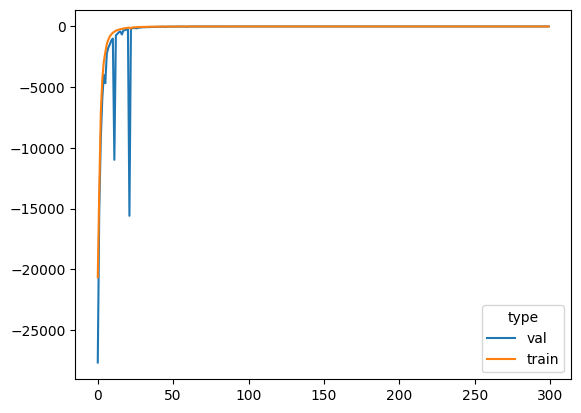

loss: tensor(213081.3438, grad_fn=<AddBackward0>) 0.021414995193481445


In [31]:
loss, score = train(model, optim, loss_fn, 300, train_loader, val_loader)

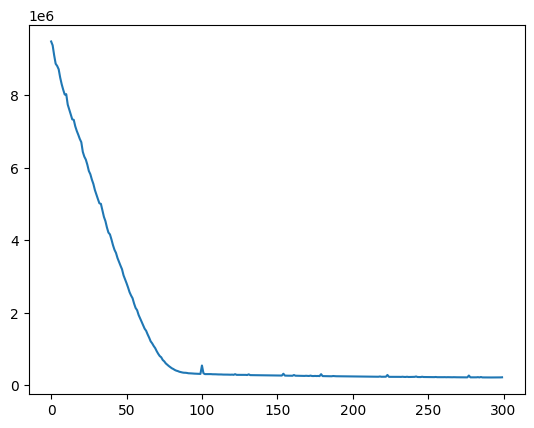

In [32]:
plt.plot(loss);

In [33]:
X_test = torch.tensor(X.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y.to_numpy(), dtype=torch.float32)
test_loader = DataLoader(list(zip(X_test, y_test)))

predictions = predict(model, test_loader)
predictions = list(map(lambda x: x.detach().numpy(), predictions))

In [34]:
predictions = list(map(lambda x: x.reshape(-1).tolist(), predictions))

In [35]:
predictions = np.array(list(chain.from_iterable(predictions)))

In [36]:
predictions = convert(predictions)

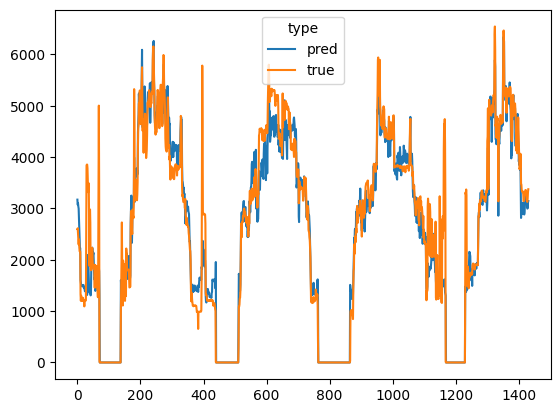

In [37]:
plt.plot(predictions, label="pred")
plt.plot(y.to_numpy(), label="true")
plt.legend(title="type");

In [38]:
r2_score(y.to_numpy(), predictions)

0.9366989484031039

In [39]:
len(data.drop(target, axis=1).columns)

6

In [40]:
out_shape = 3

In [41]:
X_new = np.array([[0] * 6])
y_new = np.array([[0] * out_shape])

In [42]:
for i in range(len(data.drop(target, axis=1).values) - out_shape):
    concat_x_data = data.drop(
        target, axis=1
    ).iloc[i].values
    concat_y_data = np.stack(
        [
            data.iloc[i + 1][target],
            data.iloc[i + 2][target],
            data.iloc[i + 3][target],
            # data.drop(
            #     get_columns_without_tagrets(target), axis=1
            # ).iloc[i + 4][target]
        ]
    )

    X_new = np.append(X_new, [concat_x_data], axis=0)
    y_new = np.append(y_new, [concat_y_data], axis=0)

In [43]:
X_new = X_new[1:]
y_new = y_new[1:]

In [44]:
input_shape = X.shape[1]
output_shape = 1 if len(y.shape) == 1 else y.shape[1]

In [45]:
class SimpleNN2(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleNN2, self).__init__()
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        # self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [46]:
X_train = torch.tensor(X_new[:900], dtype=torch.float32)
y_train = torch.tensor(y_new[:900], dtype=torch.float32)
X_val = torch.tensor(X_new[900:], dtype=torch.float32)
y_val = torch.tensor(y_new[900:], dtype=torch.float32)
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=True, batch_size=16)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle=True, batch_size=16)

In [47]:
model = SimpleNN2()
loss_fn = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), 1e-5)

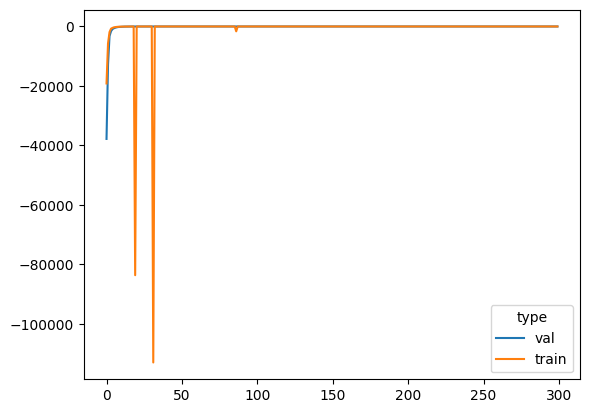

loss: tensor(283003.5625, grad_fn=<AddBackward0>) 0.0313258171081543


In [48]:
loss, score = train(model, optim, loss_fn, 300, train_loader, val_loader)

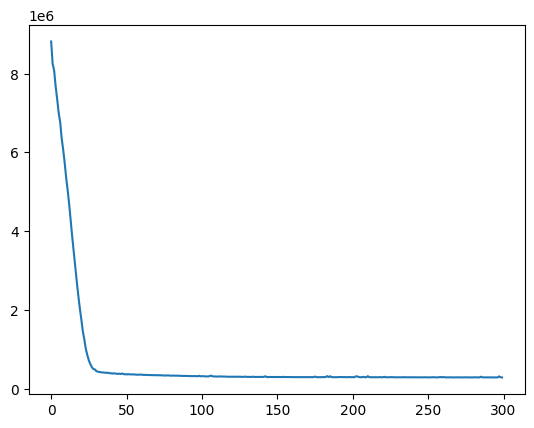

In [49]:
plt.plot(loss);

In [50]:
X_test = torch.tensor(X_new, dtype=torch.float32)
y_test = torch.tensor(y_new, dtype=torch.float32)
test_loader = DataLoader(list(zip(X_test, y_test)))

predictions = predict(model, test_loader)
predictions = list(map(lambda x: list(convert(x.detach().numpy()[0])), predictions))

In [51]:
difference = np.array([[0] * 3])
for pred, real in zip(predictions, y_test):
    difference = np.append(difference, [(real - torch.tensor(pred)).numpy()], axis=0)

In [52]:
difference = difference[1:]

In [53]:
r2_score(y_test, predictions)

0.9118926577119021

In [54]:
predictions = np.array(predictions)

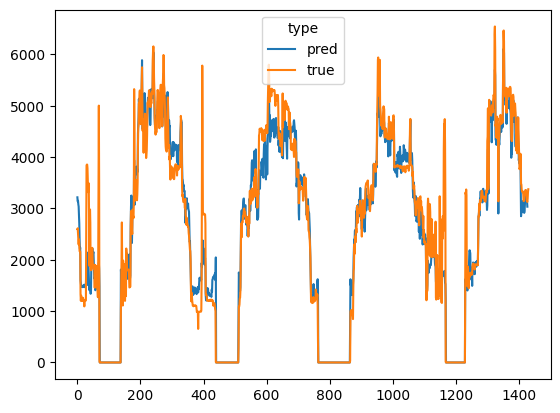

In [55]:
plt.plot(predictions[:, 0], label="pred")
plt.plot(y.to_numpy(), label="true")
plt.legend(title="type");